<a href="https://colab.research.google.com/github/mwz773/Amazon_SentimentAnalyzer/blob/main/Sentiment_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading in data

We will create a path for the kaggle dataset. We print the column names to verify that the CSV file has been loaded in.


In [ ]:
import kagglehub
import nltk.data
import nltk
import os
import pandas as pd

In [ ]:
!pip install nltk --upgrade --no-cache-dir


# Download latest version of the dataset
path = kagglehub.dataset_download("arhamrumi/amazon-product-reviews")

print("Path to dataset files:", path)

# Find the CSV file
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_file = os.path.join(path, file)
        break

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Print the column names
print("Columns in dataset:", df.columns.tolist())



Path to dataset files: /kaggle/input/amazon-product-reviews
Columns in dataset: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


# Preprocessing Inputs

Using the NLKT's library, we will perform tokenization, remove stopwords, and lemmatization on the review text. This will clean up text to be more structure and accurate.

We print the first few cleaned up reviews.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
df = df.sample(frac=0.2, random_state=42)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove punctuation and stopwords, then lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


df["Processed_Text"] = df["Text"].apply(preprocess_text)
print(df["Processed_Text"].head())

165256    tried couple brand sandwich cooky best bunch c...
231465    cat love treat ever ca find house pop top bolt...
427827    little less expected tends muddy taste expecte...
433954    first frosted original size frosted bite size ...
70260     want congratulate graphic artist putting entir...
Name: Processed_Text, dtype: object


# Building Logistic Regression model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
class LogisticRegression(object):
    def __init__(self):
        self.__weights = None
        self.__optimizer = None

    def fit(self, x, y, T, alpha, eta_decay_factor, beta, batch_size, optimizer_type, loss_func='logistic'):

        #instantiate optimizer and weights
        if optimizer_type == 'stochastic_gradient_descent':
          self.__optimizer = StochasticGradientDescent(alpha, eta_decay_factor, beta)
        elif optimizer_type == 'momentum_stochastic_gradient_descent':
          self.__optimizer = MomentumStochasticGradientDescent(alpha, eta_decay_factor, beta)
        else:
          raise ValueError('Unsupported optimizer type: {}'.format(optimizer_type))

        d = x.shape[0]
        self.__weights = np.zeros((d,1))

        loss_history = []
        for t in range(1, T + 1):

            #compute loss function
            loss = self.__compute_loss(x, y, loss_func)
            loss_history.append(loss)

            if (t % 100) == 0:
                print('Step={}  Loss={}'.format(t, loss))

            #update weights
            self.__weights = self.__optimizer.update(
                w=self.__weights,
                x=x,
                y=y,
                loss_func=loss_func,
                batch_size=batch_size,
                time_step=t)

        return loss_history


    def predict(self, x):
        #compute the linear transformation
        z = np.dot(self.__weights.T, x)

        #sigmoid function to get probabilities
        sigmoid = 1 / (1 + np.exp(-z))

        #convert to binary predictions (-1 or 1) using a threshold of 0.5
        predictions = (sigmoid >= 0.5).astype(np.float32)

        return predictions

    def __compute_loss(self, x, y, loss_func):
        if loss_func == 'logistic':
            #compute the linear transformation
            z = np.dot(self.__weights.T, x)

            #compute sigmoid function
            sigmoid = 1 / (1 + np.exp(-z))

            #compute the logistic loss using the formula:
            # Loss = - (y * log(sigmoid) + (1 - y) * log(1 - sigmoid))
            loss = -np.sum(y * np.log(sigmoid + 1e-8) + (1 - y) * np.log(1 - sigmoid + 1e-8)) / x.shape[1]
        else:
            raise ValueError('Unsupported loss function: {}'.format(loss_func))

        return loss

# Further Optimizations


We will use Ridge Regression and Stochastic Gradient Descent, and Momentum Stochastic Gradient Descent.

# Ridge Classifier


In [ ]:
class KernelRidgeClassifier(object):

    def __init__(self, kernel_func, degree=None, gamma=None):

        # Defining private variables
        self.__weights =  None
        self.__X = None
        self.__kernel_func = kernel_func
        self.__degree = degree
        self.__gamma = gamma

    def __linear_kernel(self, X1, X2):
        # Implementing linear kernel
        return X1.dot(X2.T)


    def __polynomial_kernel(self, X1, X2, degree):
        # Implementing polynomial kernel with c = 1

        gamma = self.__gamma if self.__gamma is not None else 1
        c = 1
        return (gamma * X1.dot(X2.T) + c )**degree

    def __rbf_kernel(self, X1, X2, gamma):

        # Implementing RBF kernel using Gaussian form
        gamma = gamma if gamma is not None else 1 / X1.shape[1]
        X1_norm = np.sum(X1**2, axis=1).reshape(-1, 1)
        X2_norm = np.sum(X2**2, axis=1).reshape(-1, 1)
        dist_sq = X1_norm + X2_norm.T - 2 * X1.dot(X2.T)
        return np.exp(-gamma * dist_sq)

    def fit(self, X, y, weight_decay=0):

        #Implementing the fit function

        if self.__kernel_func == 'linear':
            K = self.__linear_kernel(X, X)

        elif self.__kernel_func == 'polynomial':
            K = self.__polynomial_kernel(X, X, self.__degree)

        elif self.__kernel_func == 'rbf':
            K = self.__rbf_kernel(X, X, self.__gamma)

        else:
            raise ValueError('Unsupported kernel function: {}'.format(self.__kernel_func))

        self.__X = X
        y = y.reshape(-1, 1)
        self.__weights = np.linalg.solve(K + weight_decay * np.eye(X.shape[0]), y)

    def predict(self, X):
        # Implementing the predict function

        if self.__kernel_func == 'linear':
            K = self.__linear_kernel(X, self.__X)

        elif self.__kernel_func == 'polynomial':
            K = self.__polynomial_kernel(X, self.__X, self.__degree)

        elif self.__kernel_func == 'rbf':
            K = self.__rbf_kernel(X, self.__X, self.__gamma)

        else:
            raise ValueError('Unsupported kernel function: {}'.format(self.__kernel_func))

        return K @ self.__weights


### Training/Testing Kernel Ridge Classifier

In [ ]:
# Make Positive/Negative groups
df_subsample = df.sample(n=10000, random_state=42)
vectorize = TfidfVectorizer(max_features=5000)
X = vectorize.fit_transform(df_subsample["Processed_Text"])
Y = np.where(df_subsample["Score"] >= 4, 1, 0)

# Train/val/test split
shuffled_indices = np.random.permutation(X.shape[0])
train_split_idx = int(0.60 * X.shape[0])
val_split_idx = int(0.80 * X.shape[0])

train_indices = shuffled_indices[0:train_split_idx]
val_indices = shuffled_indices[train_split_idx:val_split_idx]
test_indices = shuffled_indices[val_split_idx:]

X_train, Y_train = X[train_indices, :], Y[train_indices]
X_val, Y_val = X[val_indices, :], Y[val_indices]
X_test, Y_test = X[test_indices, :], Y[test_indices]

model = KernelRidgeClassifier(kernel_func='rbf', gamma=0.1)
model.fit(X_train.toarray(), Y_train, weight_decay=1.0)

# Use predict function
y_test_pred = model.predict(X_test.toarray())
y_test_labels = (y_test_pred >= 0.5).astype(int)

# Evaluate classification performance
from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(Y_test, y_test_labels))
print(classification_report(Y_test, y_test_labels))


Test Accuracy: 0.832
              precision    recall  f1-score   support

           0       0.89      0.22      0.35       415
           1       0.83      0.99      0.90      1585

    accuracy                           0.83      2000
   macro avg       0.86      0.60      0.63      2000
weighted avg       0.84      0.83      0.79      2000



In [ ]:
num_examples= 10
example_indices = np.random.choice(X_test.shape[0], size=num_examples, replace=False)

original_reviews = df_subsample.iloc[test_indices[example_indices]]["Processed_Text"].values
true_labels = Y_test[example_indices]
predicted_labels = y_test_labels[example_indices]

for i in range(num_examples):
    print(f"Review {i+1}:")
    print(f"Text: {original_reviews[i]}")
    print(f"Actual Sentiment: {'Positive' if true_labels[i] == 1 else 'Negative'}")
    print(f"Predicted Sentiment: {'Positive' if predicted_labels[i] == 1 else 'Negative'} \n")


Review 1:
Text: product advertised simply open package pour popper get great tasting popcorn better personal mix lot easier highly recommended
Actual Sentiment: Positive
Predicted Sentiment: Positive 

Review 2:
Text: love food flavored lime far best key lime cooky come across addicted
Actual Sentiment: Positive
Predicted Sentiment: Positive 

Review 3:
Text: siberian husky suzy love love easy break apart give smaller section use training treat love suzy love picky eater
Actual Sentiment: Positive
Predicted Sentiment: Positive 

Review 4:
Text: forced look new hazelnut extract shop usually go watkins brand extract considering price organic factor thought might good substitute wrong flavor isnt nearly strong enough buying product
Actual Sentiment: Negative
Predicted Sentiment: Positive 

Review 5:
Text: enjoy side dead salted beetle sunflower nut product opened bag morning eating handful noticed insect leg uncovered shortly followed remaining beetle needless say avoid ordering product c

# Stochastic Gradient Descent

In [ ]:
class StochasticGradientDescent(object):
  def __init__(self, alpha, eta_decay_factor, beta):
    # initialize learning rate, decay
    self.__alpha = alpha
    self.__eta_decay_factor = eta_decay_factor
    self.__beta = beta

  def __compute_gradients(self, w, x, y, loss_func='logistic'):
    # compute gradients for logistic loss
    if loss_func == 'logistic':
      z = np.dot(w.T, x)
      sigmoid = 1 / (1 + np.exp(-z))
      error = sigmoid - y
      gradient = np.dot(x, error.T) / x.shape[1]

      return gradient
    else:
      raise ValueError('Unsupported loss function: {}'.format(loss_func))

  def _polynomial_decay(self, time_step):
    if self.__eta_decay_factor is None or time_step <= 0:
        return 1.0

    return (max(time_step, 1)) ** -self.__eta_decay_factor

  def update(self, w, x, y, loss_func, batch_size, time_step):
    learning_rate = self._polynomial_decay(time_step)

    if batch_size > x.shape[1]:
      batch_size = x.shape[1]

    # sample random batch
    indices = np.random.choice(x.shape[1], batch_size, replace=False)
    x_batch = x[:, indices]
    y_batch = y[:, indices]

    gradients = self.__compute_gradients(w, x_batch, y_batch, loss_func)
    w -= learning_rate * gradients

    return w


Training Stochastic Gradient Descent Model
Step=100  Loss=0.653122095601327
Step=200  Loss=0.638600720654063
Step=300  Loss=0.6285207246819675
Step=400  Loss=0.6206050081977703
Step=500  Loss=0.6142608266232732
Step=600  Loss=0.6088469076836933
Step=700  Loss=0.6040608807831758
Step=800  Loss=0.5997606615999793
Step=900  Loss=0.5959602083041462
Step=1000  Loss=0.5923562695437061


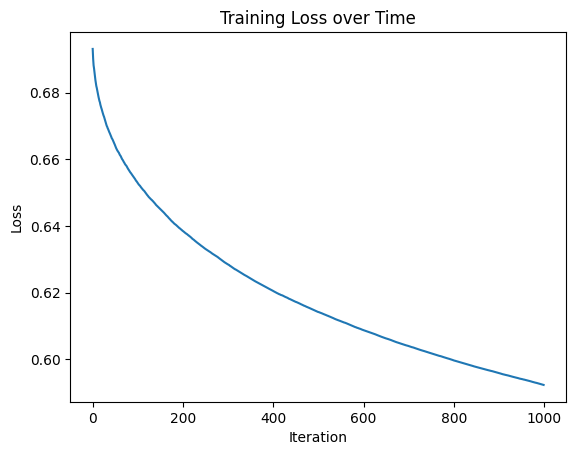

Computing the Accuracy of Stochastic Gradient Descent Model
Training set mean accuracy: 0.7839
Testing set mean accuracy: 0.7797


In [ ]:
# filter dataset to include only rows with a score from 1 to 5
df = df[df['Score'].isin([1, 2, 3, 4, 5])]

# transform to binary score (1-3 = negative, 4-5 = positive)
df['Binary_Score'] = df['Score'].apply(lambda x: 0 if x <= 3 else 1)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Processed_Text'])
y = df['Binary_Score'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.toarray().T
X_test = X_test.toarray().T
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

# training sgd model
model = LogisticRegression()
print('Training Stochastic Gradient Descent Model')
losses = model.fit(
    x=X_train,
    y=y_train,
    T=1000,
    alpha=0.001,
    eta_decay_factor=0.5,
    beta=0.0,
    batch_size=64,
    optimizer_type='stochastic_gradient_descent',
    loss_func='logistic'
)

# plot loss curve
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.show()

print('Computing the Accuracy of Stochastic Gradient Descent Model')

# calculate training mean accuracy
predictions_train = model.predict(X_train)
score_train = accuracy_score(y_train[0], predictions_train[0])
print('Training set mean accuracy: {:.4f}'.format(score_train))

# calculate testing mean accuracy
predictions_test = model.predict(X_test)
score_test = accuracy_score(y_test[0], predictions_test[0])
print('Testing set mean accuracy: {:.4f}'.format(score_test))

##SGD Confusion matrix

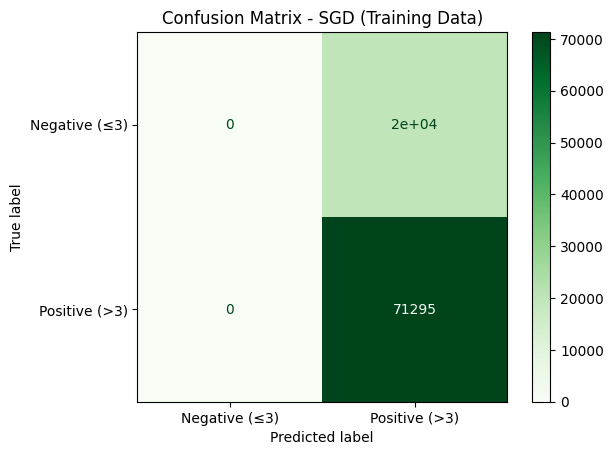

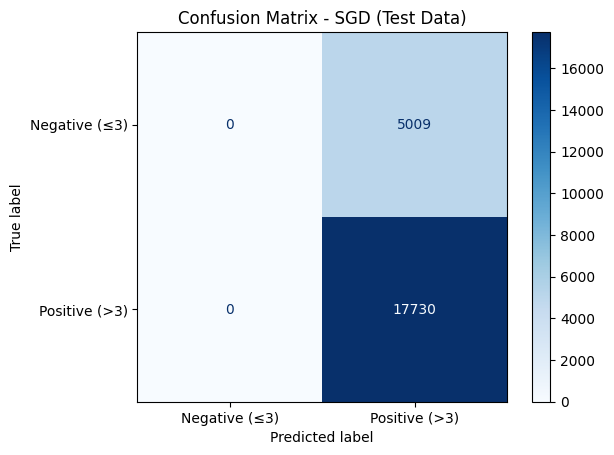

In [ ]:
train_preds = model.predict(X_train)
train_preds = train_preds[0]

cm_train = confusion_matrix(y_train[0], train_preds)
disp_train = ConfusionMatrixDisplay(
    confusion_matrix=cm_train,
    display_labels=["Negative (≤3)", "Positive (>3)"]
)
disp_train.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - SGD (Training Data)")
plt.show()

test_preds = model.predict(X_test)
test_preds = test_preds[0]

#test data
cm_test = confusion_matrix(y_test[0], test_preds)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=["Negative (≤3)", "Positive (>3)"]
)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SGD (Test Data)")
plt.show()

# Momentum Stochastic Gradient Descent

In [ ]:
class MomentumStochasticGradientDescent:
    def __init__(self, alpha, eta_decay_factor, beta):
        # initialize learning rate, decay, momentum factor
        self.__alpha = alpha
        self.__eta_decay_factor = eta_decay_factor
        self.__beta = beta
        self.__momentum = None

    def __compute_gradients(self, w, x, y, loss_func='logistic'):
        # compute gradients for logistic loss
        N = y.shape[1]
        y_hat = self.__sigmoid(np.dot(w.T, x))

        if loss_func == 'logistic':
            return np.dot(x, (y_hat - y).T).reshape(w.shape) / N
        else:
            raise ValueError('Unupported loss function: {}'.format(loss_func))

    def update(self,
               w,
               x,
               y,
               loss_func,
               batch_size,
               time_step):
        # initialize momentum vector on first call
        if self.__momentum is None:
            self.__momentum = np.zeros_like(w)

        # sample random batch
        indices = np.random.choice(x.shape[1], batch_size, replace=False)

        x_batch = x[:, indices]
        y_batch = y[:, indices]

        eta = self.__alpha / (1 + self.__eta_decay_factor * time_step)
        grad = self.__compute_gradients(w, x_batch, y_batch, loss_func)

        # update momentum and apply it to weights
        self.__momentum = self.__beta * self.__momentum + eta * grad
        w -= self.__momentum
        return w

    def __sigmoid(self, z):
          return 1 / (1 + np.exp(-z))

Training Momentum Stochastic Gradient Descent Model
Step=100  Loss=0.6905648932379767
Step=200  Loss=0.6901501950887349
Step=300  Loss=0.6899072551193203
Step=400  Loss=0.6897325771194953
Step=500  Loss=0.689598374970651
Step=600  Loss=0.6894895915097813
Step=700  Loss=0.6893995494567999
Step=800  Loss=0.6893157377733014
Step=900  Loss=0.6892442885459686
Step=1000  Loss=0.6891826931872275


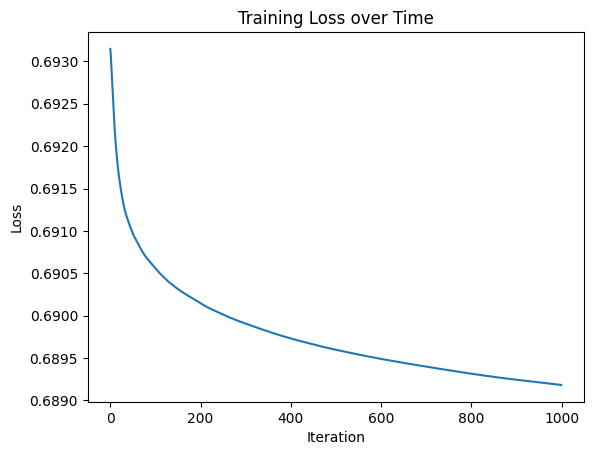

Computing the Accuracy of Momentum Stochastic Gradient Descent Model
Training set mean accuracy: 0.7839
Testing set mean accuracy: 0.7797


In [ ]:
# filter dataset to include only rows with a score from 1 to 5
df = df[df['Score'].isin([1, 2, 3, 4, 5])]

# transform to binary score (1-3 = negative, 4-5 = positive)
df['Binary_Score'] = df['Score'].apply(lambda x: 0 if x <= 3 else 1)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Processed_Text'])
y = df['Binary_Score'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.toarray().T
X_test = X_test.toarray().T
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

# training msgd model
model = LogisticRegression()
print('Training Momentum Stochastic Gradient Descent Model')
losses = model.fit(
    x=X_train,
    y=y_train,
    T=1000,
    alpha=0.05,
    eta_decay_factor=1.0,
    beta=0.8,
    batch_size=32,
    optimizer_type='momentum_stochastic_gradient_descent',
    loss_func='logistic'
)

# plot loss curve
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.show()

print('Computing the Accuracy of Momentum Stochastic Gradient Descent Model')

# calculate training mean accuracy
predictions_train = model.predict(X_train)
score_train = accuracy_score(y_train[0], predictions_train[0])
print('Training set mean accuracy: {:.4f}'.format(score_train))

# calculate testing mean accuracy
predictions_test = model.predict(X_test)
score_test = accuracy_score(y_test[0], predictions_test[0])
print('Testing set mean accuracy: {:.4f}'.format(score_test))

##Momentum SGD Confusion Matrix

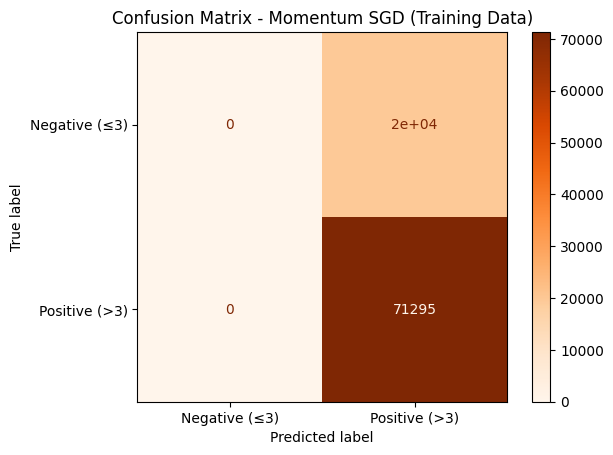

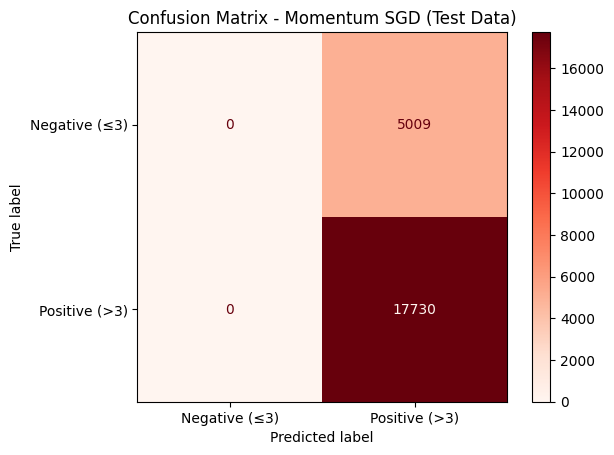

In [ ]:
train_preds = model.predict(X_train)
train_preds = train_preds[0]  # Extract predictions

#training data
cm_train = confusion_matrix(y_train[0], train_preds)
disp_train = ConfusionMatrixDisplay(
    confusion_matrix=cm_train,
    display_labels=["Negative (≤3)", "Positive (>3)"]
)
disp_train.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - Momentum SGD (Training Data)")
plt.show()


test_preds = model.predict(X_test)
test_preds = test_preds[0]

#test data
cm_test = confusion_matrix(y_test[0], test_preds)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=["Negative (≤3)", "Positive (>3)"]
)
disp_test.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix - Momentum SGD (Test Data)")
plt.show()